Merging Best Customers
=========

Igor Marfin <igor.marfin@unister.de> 


-----------


The aim of this work is to merge several lists of the best customers given by different approaches:
    
* Regression Trees
* Generalized Linear Model
* Clustering in the original parameter space
* Clustering in the pca-transformed parameter space



## Initialization
---------------------------------


One needs to *import* properly defined modules to make this analysis.  First, we would like to make automatic
numbering the sections.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


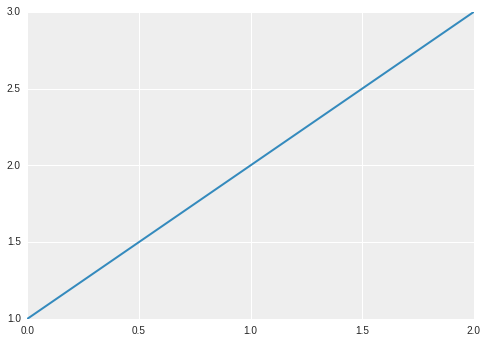

In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline

import numpy as np

import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl


# a plotter module
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd

from Dataframe import Dataframe

# Imputer
import DataFrameImputer # my own imputer

# Transformers
import Normalizer # my own transformer
from sklearn import preprocessing # a set of transformers from sklearn

# To create Pipelines of the transformers
from sklearn.pipeline import Pipeline,FeatureUnion
from TransformWrapper import TransformWrapperLambda, TransformWrapperTransformer

# use a nice style for plots and the notebook

import json
s = json.load( open("styles/my_matplotlibrc.json") )
matplotlib.rcParams.update(s)

from IPython.core.display import HTML
from IPython.display import display, Math, Latex
import urllib2


def css_styling():
    styles = open("styles/custom_v3.css", "r").read()
    return HTML(styles)
css_styling()

#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )



prefix='HR_predictive_'
plots_dir = 'plots/'

ion()

# test plotting style'
from pylab import *
plot([1,2,3])
show()


import warnings
warnings.filterwarnings("ignore", category=UserWarning)



In [2]:
data_dir = 'data/'
best_customers_DT = 'predicted_DT.csv'
best_customers_GLM = 'predicted_GLM.csv'
best_customers_Cluster_orig = 'predicted_Cluster_orig.csv'
best_customers_Cluster_pca = 'predicted_Cluster_pca.csv'

# read customers predicted by Regression Trees
predictions_DT = np.loadtxt(data_dir+best_customers_DT, delimiter=',',skiprows=1)                            
predicted_customers_DT_id=predictions_DT.T[3]
predicted_customers_DT_id = predicted_customers_DT_id.astype('int')
predicted_customers_DT_totalprice=predictions_DT.T[1]
predicted_customers_DT_totalprice = predicted_customers_DT_totalprice.astype('float')

# read customers predicted by GLM
predictions_GLM = np.loadtxt(data_dir+best_customers_GLM, delimiter=',',skiprows=1)                            
predicted_customers_GLM_id=predictions_GLM.T[3]
predicted_customers_GLM_id = predicted_customers_GLM_id.astype('int')
predicted_customers_GLM_totalprice=predictions_GLM.T[1]
predicted_customers_GLM_totalprice = predicted_customers_GLM_totalprice.astype('float')


# read customers predicted by Clustering in the original customer parameters
predictions_customers_Cluster_orig = np.loadtxt(data_dir+best_customers_Cluster_orig, delimiter=',',skiprows=1)                            
predicted_customers_Cluster_orig_id=predictions_customers_Cluster_orig.T[1]
predicted_customers_Cluster_orig_id = predicted_customers_Cluster_orig_id.astype('int')
predicted_customers_Cluster_orig_totalprice=predictions_customers_Cluster_orig.T[0]
predicted_customers_Cluster_orig_totalprice = predicted_customers_Cluster_orig_totalprice.astype('float')

# read customers predicted by Clustering in the pca-transformed customer parameters
predictions_customers_Cluster_pca = np.loadtxt(data_dir+best_customers_Cluster_pca, delimiter=',',skiprows=1)                            
predicted_customers_Cluster_pca_id=predictions_customers_Cluster_pca.T[1]
predicted_customers_Cluster_pca_id = predicted_customers_Cluster_pca_id.astype('int')
predicted_customers_Cluster_pca_totalprice=predictions_customers_Cluster_pca.T[0]
predicted_customers_Cluster_pca_totalprice = predicted_customers_Cluster_pca_totalprice.astype('float')




Consistency checks
----------------------------

---------------------------------

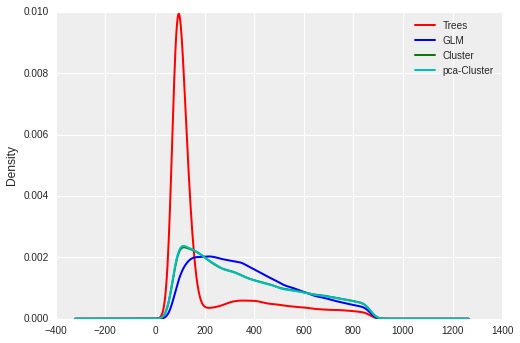

In [7]:
# plot total_price of the selected customers

pd.Series(predicted_customers_DT_totalprice).plot(kind='kde',legend=True,label='Trees',c='r')
pd.Series(predicted_customers_GLM_totalprice).plot(kind='kde',legend=True,label='GLM',c='b')
pd.Series(predicted_customers_Cluster_orig_totalprice).plot(kind='kde',legend=True,label='Cluster',c='g')
pd.Series(predicted_customers_Cluster_pca_totalprice).plot(kind='kde',legend=True,label='pca-Cluster',c='c')
pl.legend()
#pl.savefig(plots_dir+prefix+'total_price'+'.png')

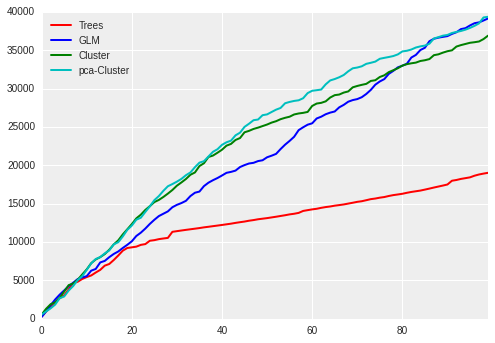

In [32]:


# plot a Cumulative Sum of the 'timeseries' of the total_price. A 'timeseries' is the series of the data 
# in the order as  they are stored in the csv file.
data = {
        'Trees':predicted_customers_DT_totalprice[::1000].tolist(),
        'GLM':predicted_customers_GLM_totalprice[::1000].tolist(),
        'Cluster':predicted_customers_Cluster_orig_totalprice[::1000].tolist(),
        'pca-Cluster':predicted_customers_Cluster_pca_totalprice[::1000].tolist()    
        }
data=pd.DataFrame(data).cumsum()
data['Trees'].plot(legend=True,label='Trees',c='r')
data['GLM'].plot(legend=True,label='GLM',c='b')
data['Cluster'].plot(legend=True,label='Cluster',c='g')
data['pca-Cluster'].plot(legend=True,label='pca-Cluster',c='c')



It seems that the customers starting from the index of 20000 for the Regreesion Trees shows the worst cumulative total_price among all customers.

Perhaps, it's a good idea to exclude them from merging

Merging
-----------------

---------------------

Let's do the logical AND of best customers from two different approaches in different pairs.
Then we merge obtained customers in one list. Then we remove duplicates.


In [28]:
# define the overlapping function
def overlap(arr1,arr2):
    _overlap=np.intersect1d(arr1,arr2)
    _max=max(len(arr1),len(arr2))
    return _overlap,float(_overlap.shape[0])/_max


# the list of the predicted cluster ids from different algos.
 


# exclude the worst (20000,100000] customers given by 'Regression Trees'  
cluster_ids = [predicted_customers_DT_id[:20000],predicted_customers_GLM_id,predicted_customers_Cluster_orig_id,predicted_customers_Cluster_pca_id]
#cluster_ids = [predicted_customers_DT_id,predicted_customers_GLM_id,predicted_customers_Cluster_orig_id,predicted_customers_Cluster_pca_id]

merged=np.array([])
for i in range(len(cluster_ids)):
    for j in range(i+1,len(cluster_ids)):        
        print "i=",i,"  j=",j
        overlapping,percentage = overlap(cluster_ids[i],cluster_ids[j])
        print '%% of the overlapping: %.3f, size of the intersection: %d'%(percentage,len(overlapping))
        merged = np.concatenate((overlapping,merged),axis=0)

        
merged = merged.astype('int')
print '\n\nsize of merged customers: %d'%len(merged)

# remove duplicates
merged = np.unique(merged)
print '\n\nsize of the unique and merged customers: %d'%len(merged)


# save the result to the file
file_for_results='predicted_merged'
data = {
            'ClusterID':merged
    
        }

data=pd.DataFrame(data)

data.to_csv(data_dir+file_for_results+'.csv', sep=',',index=False,encoding='utf-8')
# print a few customers 
data.head(10)


i= 0   j= 1
% of the overlapping: 0.095, size of the intersection: 9470
i= 0   j= 2
% of the overlapping: 0.135, size of the intersection: 13515
i= 0   j= 3
% of the overlapping: 0.134, size of the intersection: 13414
i= 1   j= 2
% of the overlapping: 0.367, size of the intersection: 36670
i= 1   j= 3
% of the overlapping: 0.365, size of the intersection: 36462
i= 2   j= 3
% of the overlapping: 0.753, size of the intersection: 75340


size of merged customers: 184871


size of the unique and merged customers: 90959


ClusterID
0        490
1        549
2        743
3       1093
4       1155
5       1181
6       1583
7       1623
8       1887
9       2174